In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
import glob

In [3]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [4]:
def event_size(df):
    return len(np.unique(df.event))

In [5]:
def event_ekin(df):
    grdf = df.groupby('event')
    ekin = grdf['ekin'].sum()
    return ekin

In [6]:
def select_gammas_interact_in_crystal(df):
    grdf = df.groupby('event_id')
    return grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )


In [7]:
def fixdf(gdfx):
    gdf = gdfx.copy().drop(columns=['volume','primary','motherid', 'name'])
    grdf = gdf.groupby('event')
    gdfa = grdf.agg(
                etot = ('ekin', 'sum'),
                ntrk = ('ekin', 'count')).reset_index()
    
    return pd.merge(gdf, gdfa, on='event').drop(columns=['level_0','index'])

In [8]:
def fixdf_gcol(df, col):
    grdf = df.groupby('event')
    return grdf[col].first()

In [9]:
def fixdf_classify(df):
    grdf = df.groupby('event')
    return grdf.size()

In [10]:
def select_large_etot(df, ecut=0.511):
    grdf = df.groupby('event')
    return grdf.filter(lambda x: (x.etot > ecut)  )


In [11]:
def fiducial_select(df, d=48.2, z=37.2):
    df2 = df[np.abs(df['x'])<d/2]
    df3 = df2[np.abs(df2['y'])<d/2]
    df4 = df3[np.abs(df3['z'])<z/2]
    
    return df4


In [12]:
def fixdf_energy_select(df, emax=0.45):
    grouped = df.groupby('event')
    return grouped.filter(lambda x: x['etot'].max() > emax)


In [13]:
def create_ordered_df(df):
    grouped = df.groupby('event')

    # Initialize lists to store results
    results = []
    
    # Iterate over each event group
    for event_id, group in grouped:
        # Sort particles by energy in descending order
        sorted_group = group.sort_values(by='ekin', ascending=False).reset_index(drop=True)
        
        # Extract ntrak and proc from the first particle (they are the same for all particles in the event)
        event = sorted_group.loc[0, 'event']
        ntrk = sorted_group.loc[0, 'ntrk']
        proc = sorted_group.loc[0, 'proc']
        
        # Get particle with maximum energy
        x1, y1, z1, e1 = sorted_group.loc[0, ['x', 'y', 'z', 'ekin']]
        
        # Get particle with second maximum energy (if available)
        if len(sorted_group) > 1:
            x2, y2, z2, e2 = sorted_group.loc[1, ['x', 'y', 'z', 'ekin']]
        else:
            x2, y2, z2, e2 = None, None, None, None  # If no second particle, set to None
        
        # Calculate the baricenter of x1, y1, z1, e1 and x2, y2, z2, e2
        if e2 is not None:
            x12 = (x1 * e1 + x2 * e2) / (e1 + e2)
            y12 = (y1 * e1 + y2 * e2) / (e1 + e2)
            z12 = (z1 * e1 + z2 * e2) / (e1 + e2)
        else:
            x12, y12, z12 = x1, y1, z1  # If only one particle, baricenter is that particle's coordinates
        
        # Calculate the baricenter of all particles in the event
        total_energy = group['ekin'].sum()
        xb = (group['x'] * group['ekin']).sum() / total_energy
        yb = (group['y'] * group['ekin']).sum() / total_energy
        zb = (group['z'] * group['ekin']).sum() / total_energy
        
        # Append the results
        results.append({'event':event,
            'ntrk': ntrk,
            'proc': proc,
            'x1': x1, 'y1': y1, 'z1': z1, 'e1': e1,
            'x2': x2, 'y2': y2, 'z2': z2, 'e2': e2,
            'x12': x12, 'y12': y12, 'z12': z12,
            'xb': xb, 'yb': yb, 'zb': zb
        })
    
    # Create the final DataFrame
    return pd.DataFrame(results)
    


In [14]:
def xclass(df):
    phot = df[df['proc'] == "phot"]
    compt = df[df['proc'] == "compt"]
    return phot.size/df.size, compt.size/odf.size

In [15]:
def add_distances(df):
    # Calculate d12: Distance between (x1, y1, z1) and (x2, y2, z2)
    df['d12'] = np.sqrt((df['x2'] - df['x1'])**2 + (df['y2'] - df['y1'])**2 + (df['z2'] - df['z1'])**2)
    
    # Calculate d12b: Distance between (x12, y12, z12) and (xb, yb, zb)
    df['d12b'] = np.sqrt((df['xb'] - df['x12'])**2 + (df['yb'] - df['y12'])**2 + (df['zb'] - df['z12'])**2)

    return df


## BGO
- BGO crystal case. Dimensions of 48.2 x 48.2 x X0 (37.2)

In [16]:
rootdir = "/Users/jjgomezcadenas/Data/G4Prods/crystalGI/BGO"
filenm = "gamma_interactions_bgo_1.csv"


In [17]:
df = pd.read_csv(f"{rootdir}/{filenm}", header=0)

In [18]:
df.head(10)

,event,trkid,name,primary,motherid,x,y,z,t,ekin,proc,volume
0,0,1,gamma,1,0,20.16540,-6.42771,-11.100000,0.000000,0.511000,Primary,CRYSTAL
1,0,4,e-,0,1,22.61070,-8.02806,1.747640,0.049079,0.247639,phot,CRYSTAL
2,0,3,e-,0,1,22.12800,-9.52672,0.602702,0.042585,0.178315,compt,CRYSTAL
3,0,2,e-,0,1,20.16540,-6.42771,-5.188930,0.019717,0.068650,compt,CRYSTAL
4,1,1,gamma,1,0,-10.12970,-19.90340,-11.100000,0.000000,0.511000,Primary,CRYSTAL
5,1,3,e-,0,1,-3.22577,-16.78100,1.781140,0.052539,0.392802,phot,CRYSTAL
6,1,2,e-,0,1,-10.12970,-19.90340,-6.788300,0.014382,0.102479,compt,CRYSTAL
7,2,1,gamma,1,0,8.55399,-21.61080,-11.100000,0.000000,0.511000,Primary,CRYSTAL
8,2,2,e-,0,1,8.55399,-21.61080,5.521600,0.055444,0.497574,phot,CRYSTAL
9,3,1,gamma,1,0,1.87170,-20.91490,-11.100000,0.000000,0.511000,Primary,CRYSTAL


### Remove primary gammas and Bremsstrhalung gammas 
- Removing primary gammas also removes events in which the gamma does not interact (only secondaries)
- Removing Bremss is needed to avoid double counting

In [19]:
gdf = df[df['primary'] == 0].reset_index()

In [20]:
gdf.head(10)

,index,event,trkid,name,primary,motherid,x,y,z,t,ekin,proc,volume
0,1,0,4,e-,0,1,22.610700,-8.02806,1.747640,0.049079,0.247639,phot,CRYSTAL
1,2,0,3,e-,0,1,22.128000,-9.52672,0.602702,0.042585,0.178315,compt,CRYSTAL
2,3,0,2,e-,0,1,20.165400,-6.42771,-5.188930,0.019717,0.068650,compt,CRYSTAL
3,5,1,3,e-,0,1,-3.225770,-16.78100,1.781140,0.052539,0.392802,phot,CRYSTAL
4,6,1,2,e-,0,1,-10.129700,-19.90340,-6.788300,0.014382,0.102479,compt,CRYSTAL
5,8,2,2,e-,0,1,8.553990,-21.61080,5.521600,0.055444,0.497574,phot,CRYSTAL
6,10,3,2,e-,0,1,1.871700,-20.91490,-7.577870,0.011749,0.420466,phot,CRYSTAL
7,12,4,2,e-,0,1,9.212210,-4.04386,-6.087650,0.016719,0.494604,phot,CRYSTAL
8,14,5,2,e-,0,1,0.637559,11.49590,-8.605640,0.008320,0.420466,phot,CRYSTAL
9,17,7,2,e-,0,1,-16.384900,-22.70310,-0.935871,0.033904,0.420466,phot,CRYSTAL


In [21]:
event_size(gdf)/event_size(df)

0.87184

### Bremss
- The plot below show that a few events have more than 511 keV. This is due to bremss gammas wich are double counted (since the energy of the electron that emits them is counted).

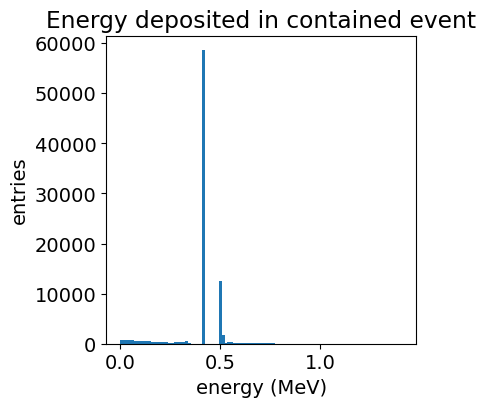

In [22]:
b, e = histoplot(event_ekin(gdf), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

### Remove Bremss
- Simply asking that particles in the df come from the primary particle will eliminate bremss photons.

In [23]:
gdf2 = gdf[gdf['motherid'] == 1].reset_index()

In [24]:
event_size(gdf2)/event_size(df)

0.87184

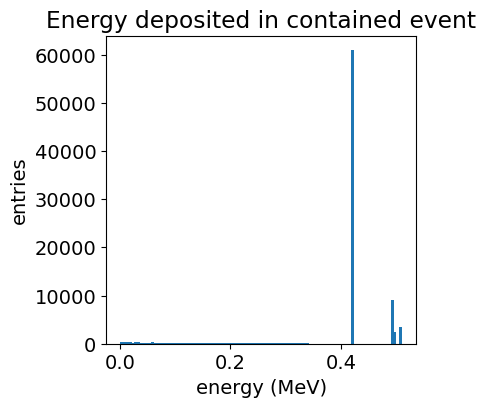

In [25]:
b, e = histoplot(event_ekin(gdf2), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

### "Fix" dataframe
- add total energy and number of particles in the event
- remove name, primary and motherid (its alwasy e-, 0 and 1)

In [26]:
gdf3 = fixdf(gdf2)

In [27]:
gdf3.head(10)

,event,trkid,x,y,z,t,ekin,proc,etot,ntrk
0,0,4,22.610700,-8.02806,1.747640,0.049079,0.247639,phot,0.494604,3
1,0,3,22.128000,-9.52672,0.602702,0.042585,0.178315,compt,0.494604,3
2,0,2,20.165400,-6.42771,-5.188930,0.019717,0.068650,compt,0.494604,3
3,1,3,-3.225770,-16.78100,1.781140,0.052539,0.392802,phot,0.495281,2
4,1,2,-10.129700,-19.90340,-6.788300,0.014382,0.102479,compt,0.495281,2
5,2,2,8.553990,-21.61080,5.521600,0.055444,0.497574,phot,0.497574,1
6,3,2,1.871700,-20.91490,-7.577870,0.011749,0.420466,phot,0.420466,1
7,4,2,9.212210,-4.04386,-6.087650,0.016719,0.494604,phot,0.494604,1
8,5,2,0.637559,11.49590,-8.605640,0.008320,0.420466,phot,0.420466,1
9,7,2,-16.384900,-22.70310,-0.935871,0.033904,0.420466,phot,0.420466,1


In [28]:
event_size(gdf3)/event_size(df)

0.87184

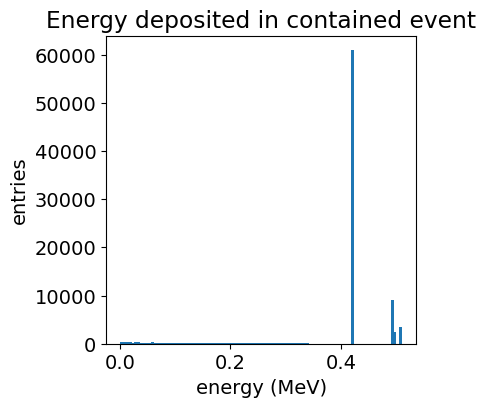

In [29]:
b, e = histoplot(fixdf_gcol(gdf3, 'etot'), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

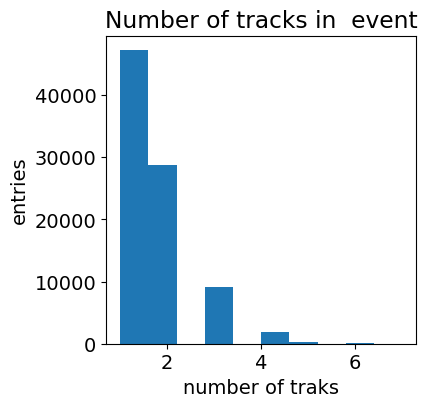

In [30]:
b, e = histoplot(fixdf_gcol(gdf3, 'ntrk'), 'number of traks', "entries", bins=10, figsize=(6,6),
                title="Number of tracks in  event")

In [31]:
print(f" number of events with 1 particle = {b[0]/np.sum(b)}")

 number of events with 1 particle = 0.5415213800697376


In [32]:
gdf4 = fiducial_select(gdf3, d=48.2, z=22.0)

In [33]:
gdf4.head(10)

,event,trkid,x,y,z,t,ekin,proc,etot,ntrk
0,0,4,22.610700,-8.02806,1.747640,0.049079,0.247639,phot,0.494604,3
1,0,3,22.128000,-9.52672,0.602702,0.042585,0.178315,compt,0.494604,3
2,0,2,20.165400,-6.42771,-5.188930,0.019717,0.068650,compt,0.494604,3
3,1,3,-3.225770,-16.78100,1.781140,0.052539,0.392802,phot,0.495281,2
4,1,2,-10.129700,-19.90340,-6.788300,0.014382,0.102479,compt,0.495281,2
5,2,2,8.553990,-21.61080,5.521600,0.055444,0.497574,phot,0.497574,1
6,3,2,1.871700,-20.91490,-7.577870,0.011749,0.420466,phot,0.420466,1
7,4,2,9.212210,-4.04386,-6.087650,0.016719,0.494604,phot,0.494604,1
8,5,2,0.637559,11.49590,-8.605640,0.008320,0.420466,phot,0.420466,1
9,7,2,-16.384900,-22.70310,-0.935871,0.033904,0.420466,phot,0.420466,1


In [34]:
event_size(gdf4)/event_size(gdf3)

0.9894361350706552

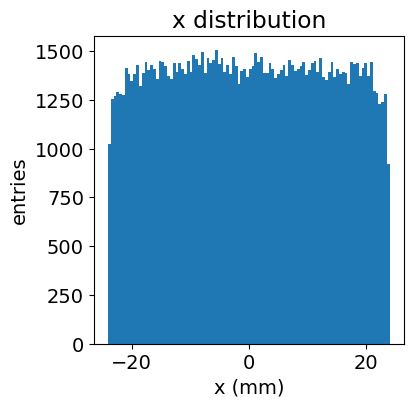

In [35]:
b, e = histoplot(gdf4.x, "x (mm)", "entries", bins=100, figsize=(4,4),
                title="x distribution")

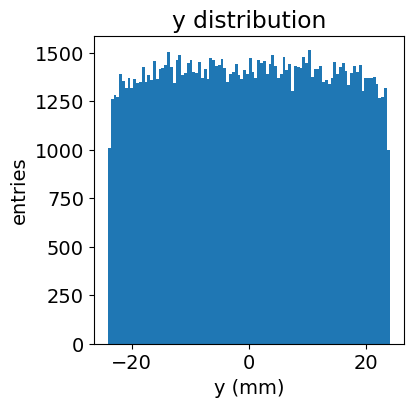

In [36]:
b, e = histoplot(gdf4.y, "y (mm)", "entries", bins=100, figsize=(4,4),
                title="y distribution")

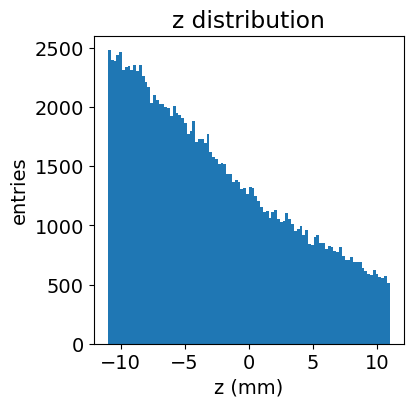

In [37]:
b, e = histoplot(gdf4.z, "z (mm)", "entries", bins=100, figsize=(4,4),
                title="z distribution")

In [38]:
gdf5 = gdf4[gdf4['ntrk']==1] # should select strictly photo and low energy compton

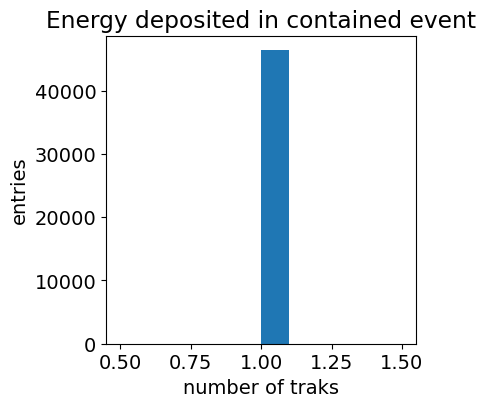

In [39]:
b, e = histoplot(gdf5.ntrk, 'number of traks', "entries", bins=10, figsize=(6,6),
                title="Energy deposited in contained event")

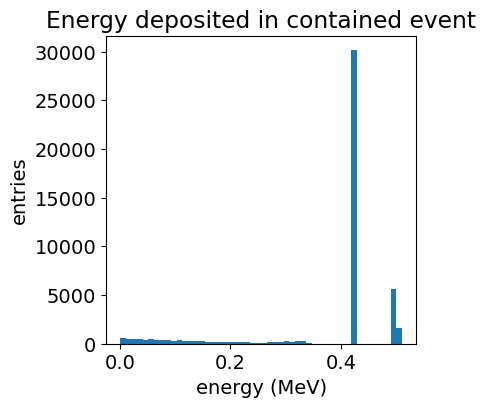

In [40]:
b, e = histoplot(event_ekin(gdf5), 'energy (MeV)', "entries", bins=50, figsize=(6,6),
                title="Energy deposited in contained event")

In [41]:
np.sum(b[40:50])/np.sum(b)

0.8061636006814897

In [42]:
photdf = fixdf_energy_select(gdf5, emax=0.40)

In [43]:
photdf

,event,trkid,x,y,z,t,ekin,proc,etot,ntrk
5,2,2,8.553990,-21.61080,5.521600,0.055444,0.497574,phot,0.497574,1
6,3,2,1.871700,-20.91490,-7.577870,0.011749,0.420466,phot,0.420466,1
7,4,2,9.212210,-4.04386,-6.087650,0.016719,0.494604,phot,0.494604,1
8,5,2,0.637559,11.49590,-8.605640,0.008320,0.420466,phot,0.420466,1
9,7,2,-16.384900,-22.70310,-0.935871,0.033904,0.420466,phot,0.420466,1
...,...,...,...,...,...,...,...,...,...,...
140894,99987,2,1.399150,20.13820,-2.854610,0.027504,0.420466,phot,0.420466,1
140897,99990,2,-10.843000,-4.83556,-9.242830,0.006195,0.420466,phot,0.420466,1
140898,99991,2,6.460710,2.55522,-1.760170,0.031154,0.420466,phot,0.420466,1
140903,99994,2,14.421000,-10.32580,0.829837,0.039794,0.420466,phot,0.420466,1


In [44]:
event_size(photdf)/event_size(df)

0.37381

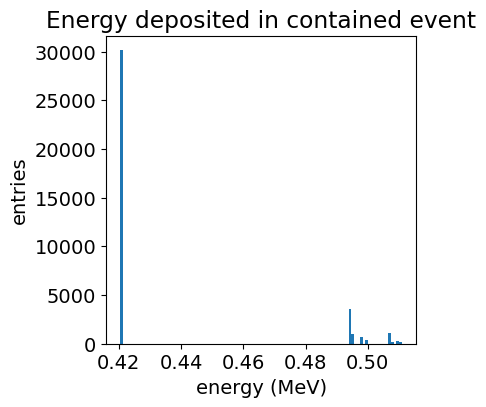

In [45]:
b, e = histoplot(event_ekin(photdf), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

In [46]:
phlkdf = fixdf_energy_select(gdf4, emax=0.40)  # This is the fraction of events (COMPT + PE) near the peak

In [47]:
event_size(phlkdf)/event_size(df)

0.75215

In [48]:
phlkdf.head(10)

,event,trkid,x,y,z,t,ekin,proc,etot,ntrk
0,0,4,22.610700,-8.02806,1.747640,0.049079,0.247639,phot,0.494604,3
1,0,3,22.128000,-9.52672,0.602702,0.042585,0.178315,compt,0.494604,3
2,0,2,20.165400,-6.42771,-5.188930,0.019717,0.068650,compt,0.494604,3
3,1,3,-3.225770,-16.78100,1.781140,0.052539,0.392802,phot,0.495281,2
4,1,2,-10.129700,-19.90340,-6.788300,0.014382,0.102479,compt,0.495281,2
5,2,2,8.553990,-21.61080,5.521600,0.055444,0.497574,phot,0.497574,1
6,3,2,1.871700,-20.91490,-7.577870,0.011749,0.420466,phot,0.420466,1
7,4,2,9.212210,-4.04386,-6.087650,0.016719,0.494604,phot,0.494604,1
8,5,2,0.637559,11.49590,-8.605640,0.008320,0.420466,phot,0.420466,1
9,7,2,-16.384900,-22.70310,-0.935871,0.033904,0.420466,phot,0.420466,1


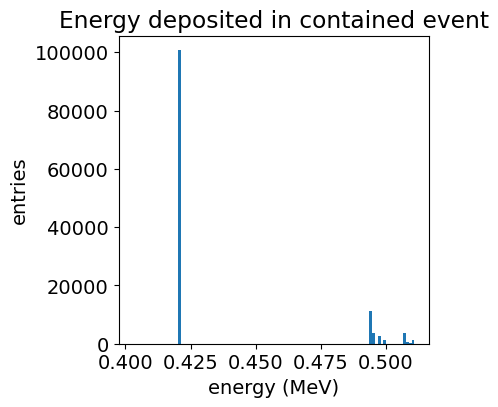

In [49]:
b, e = histoplot(phlkdf.etot, 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

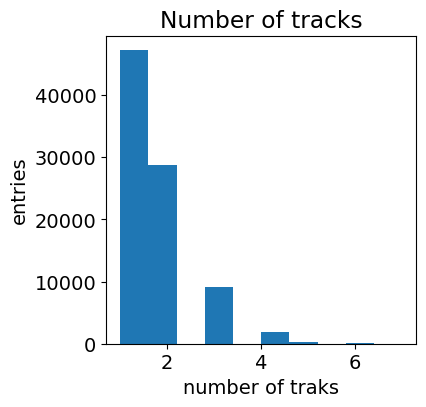

In [50]:
b, e = histoplot(fixdf_gcol(gdf3, 'ntrk'), 'number of traks', "entries", bins=10, figsize=(6,6),
                title="Number of tracks")

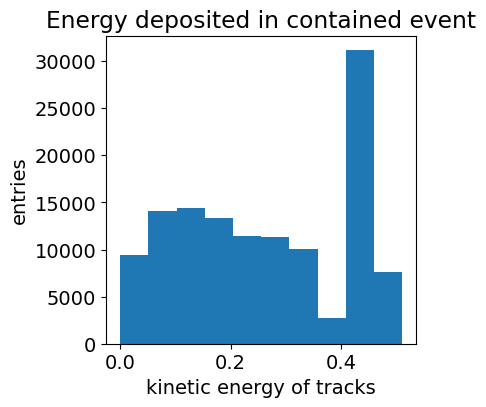

In [51]:
b, e = histoplot(phlkdf.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="Energy deposited in contained event")

In [52]:
phlk1 = phlkdf[phlkdf['ntrk']==1]

In [53]:
event_size(phlk1)/event_size(df)

0.37381

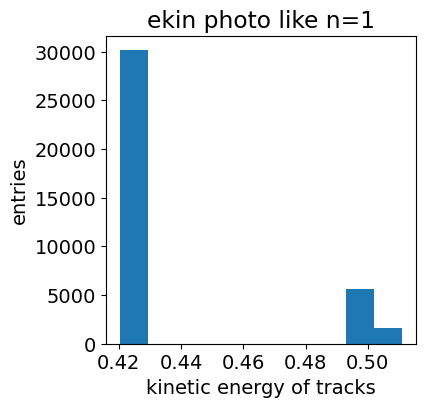

In [54]:
b, e = histoplot(phlk1.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="ekin photo like n=1")

In [55]:
phlk2 = phlkdf[phlkdf['ntrk']==2]

In [56]:
event_size(phlk2)/event_size(df)

0.26875

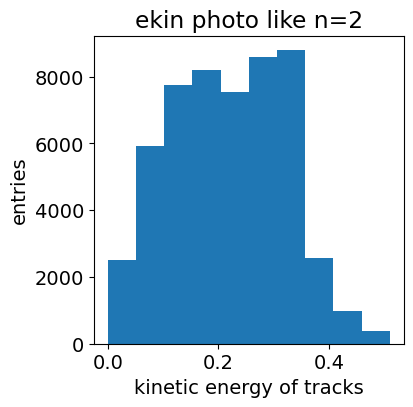

In [57]:
b, e = histoplot(phlk2.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="ekin photo like n=2")

In [58]:
phlk3 = phlkdf[phlkdf['ntrk']==3]

In [59]:
event_size(phlk3)/event_size(df)

0.08835

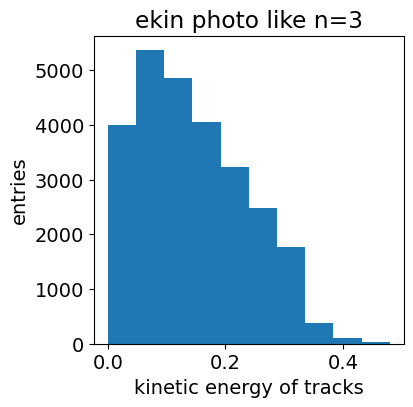

In [60]:
b, e = histoplot(phlk3.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="ekin photo like n=3")

In [61]:
phlkn = phlkdf[phlkdf['ntrk']>3]

In [62]:
event_size(phlkn)/event_size(df)

0.02124

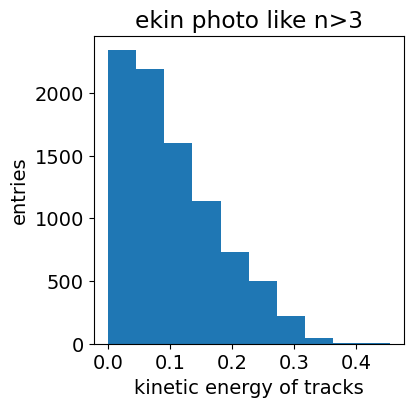

In [63]:
b, e = histoplot(phlkn.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="ekin photo like n>3")

In [64]:
odf = create_ordered_df(phlkdf) 

In [65]:
odf

,event,ntrk,proc,x1,y1,z1,e1,x2,y2,z2,e2,x12,y12,z12,xb,yb,zb
0,0,3,phot,22.61070,-8.02806,1.747640,0.247639,22.128000,-9.52672,0.602702,0.178315,22.408630,-8.655437,1.268340,22.097274,-8.346233,0.372085
1,1,2,phot,-3.22577,-16.78100,1.781140,0.392802,-10.129700,-19.90340,-6.788300,0.102479,-4.654268,-17.427058,0.008030,-4.654268,-17.427058,0.008030
2,2,1,phot,8.55399,-21.61080,5.521600,0.497574,NaN,NaN,NaN,NaN,8.553990,-21.610800,5.521600,8.553990,-21.610800,5.521600
3,3,1,phot,1.87170,-20.91490,-7.577870,0.420466,NaN,NaN,NaN,NaN,1.871700,-20.914900,-7.577870,1.871700,-20.914900,-7.577870
4,4,1,phot,9.21221,-4.04386,-6.087650,0.494604,NaN,NaN,NaN,NaN,9.212210,-4.043860,-6.087650,9.212210,-4.043860,-6.087650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75210,99994,1,phot,14.42100,-10.32580,0.829837,0.420466,NaN,NaN,NaN,NaN,14.421000,-10.325800,0.829837,14.421000,-10.325800,0.829837
75211,99995,2,phot,-6.03496,12.58190,7.355550,0.381972,-6.358890,11.31680,4.321410,0.038494,-6.064616,12.466080,7.077775,-6.064616,12.466080,7.077775
75212,99996,3,phot,-12.17780,2.39542,1.656900,0.200462,-8.431760,4.92987,-0.864967,0.158702,-10.522556,3.515305,0.542575,-10.402473,3.739266,0.449774
75213,99997,3,phot,4.32436,-21.15970,7.664320,0.331053,-0.002558,-16.91740,-3.079380,0.054896,3.708915,-20.556290,6.136175,3.708812,-20.588275,6.211124


In [66]:
fp, fc = xclass(odf)
print(f"Fraction of photoelectric events with e > ecut = {fp}, of compton = {fc}")

Fraction of photoelectric events with e > ecut = 0.7104566908196503, of compton = 0.28954330918034965


In [67]:
odf = add_distances(odf)

In [68]:
odf

,event,ntrk,proc,x1,y1,z1,e1,x2,y2,z2,e2,x12,y12,z12,xb,yb,zb,d12,d12b
0,0,3,phot,22.61070,-8.02806,1.747640,0.247639,22.128000,-9.52672,0.602702,0.178315,22.408630,-8.655437,1.268340,22.097274,-8.346233,0.372085,1.946757,0.997910
1,1,2,phot,-3.22577,-16.78100,1.781140,0.392802,-10.129700,-19.90340,-6.788300,0.102479,-4.654268,-17.427058,0.008030,-4.654268,-17.427058,0.008030,11.438922,0.000000
2,2,1,phot,8.55399,-21.61080,5.521600,0.497574,NaN,NaN,NaN,NaN,8.553990,-21.610800,5.521600,8.553990,-21.610800,5.521600,NaN,0.000000
3,3,1,phot,1.87170,-20.91490,-7.577870,0.420466,NaN,NaN,NaN,NaN,1.871700,-20.914900,-7.577870,1.871700,-20.914900,-7.577870,NaN,0.000000
4,4,1,phot,9.21221,-4.04386,-6.087650,0.494604,NaN,NaN,NaN,NaN,9.212210,-4.043860,-6.087650,9.212210,-4.043860,-6.087650,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75210,99994,1,phot,14.42100,-10.32580,0.829837,0.420466,NaN,NaN,NaN,NaN,14.421000,-10.325800,0.829837,14.421000,-10.325800,0.829837,NaN,0.000000
75211,99995,2,phot,-6.03496,12.58190,7.355550,0.381972,-6.358890,11.31680,4.321410,0.038494,-6.064616,12.466080,7.077775,-6.064616,12.466080,7.077775,3.303243,0.000000
75212,99996,3,phot,-12.17780,2.39542,1.656900,0.200462,-8.431760,4.92987,-0.864967,0.158702,-10.522556,3.515305,0.542575,-10.402473,3.739266,0.449774,5.178423,0.270537
75213,99997,3,phot,4.32436,-21.15970,7.664320,0.331053,-0.002558,-16.91740,-3.079380,0.054896,3.708915,-20.556290,6.136175,3.708812,-20.588275,6.211124,12.334765,0.081489


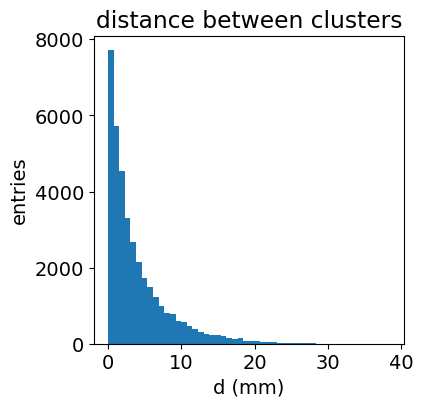

In [69]:
b, e = histoplot(odf.d12.dropna(), 'd (mm)', "entries", bins=50, figsize=(6,6),
                title="distance between clusters")

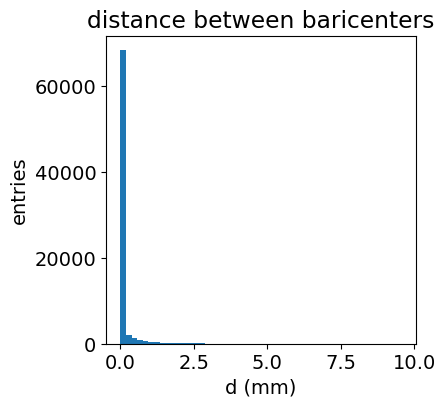

In [70]:
b, e = histoplot(odf.d12b.dropna(), 'd (mm)', "entries", bins=50, figsize=(6,6),
                title="distance between baricenters")

In [71]:
def scatter_xyz(df):
    fig, axs = plt.subplots(2, 2, figsize=(18, 9))
    
    # Scatter plot for x1 vs x2
    axs[0,0].scatter(df['x1'], df['x2'], alpha=0.7, edgecolor='k')
    axs[0,0].set_title('Scatter plot: x1 vs x2')
    axs[0,0].set_xlabel('x1')
    axs[0,0].set_ylabel('x2')
    
    # Scatter plot for y1 vs y2
    axs[0,1].scatter(df['y1'], df['y2'], alpha=0.7, edgecolor='k')
    axs[0,1].set_title('Scatter plot: y1 vs y2')
    axs[0,1].set_xlabel('y1')
    axs[0,1].set_ylabel('y2')
    
    # Scatter plot for z1 vs z2
    axs[1,0].scatter(df['z1'], df['z2'], alpha=0.7, edgecolor='k')
    axs[1,0].set_title('Scatter plot: z1 vs z2')
    axs[1,0].set_xlabel('z1')
    axs[1,0].set_ylabel('z2')
    
    # Scatter plot for e1 vs e2
    axs[1,1].scatter(df['e1'], df['e2'], alpha=0.7, edgecolor='k')
    axs[1,1].set_title('Scatter plot: e1 vs e2')
    axs[1,1].set_xlabel('e1')
    axs[1,1].set_ylabel('e2')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plots
    plt.show()


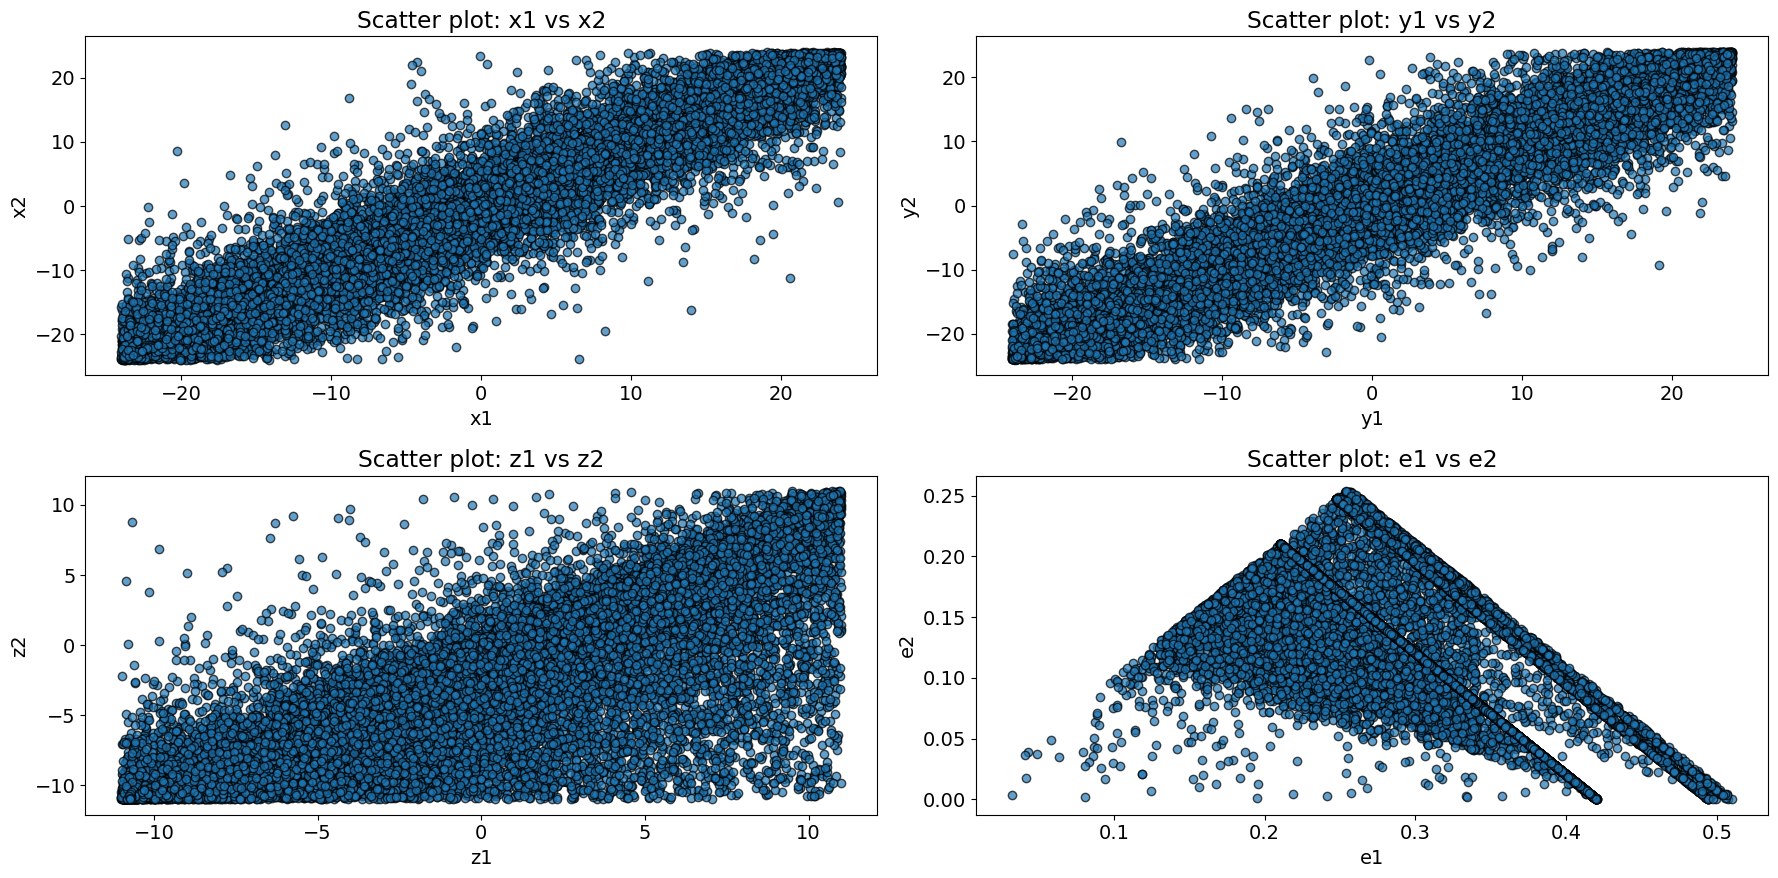

In [72]:
scatter_xyz(odf)